**Energy Price Prediction in Spain**

> The dataset contains the electrical consumption, generation, pricing, and weather data of Spain for the years 2015 to 2019. The increasing amount of renewable energies results in new challenges for operating the electrical grid. Forecasting in the energy market is becoming one of the highest leverage contribution areas of Data Science. In this project we investigate how generation, load and weather measurements influence the prices of electricity in Spain.




## EKRA9034, 530234003

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
from pathlib import Path
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, ExpSineSquared
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn

2023-05-27 17:44:54.666470: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 17:44:55.848839: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-27 17:44:55.857378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 17:44:59.010183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/elli/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data from csv files


In [3]:
def data_loader():
    dirname = str(Path(os.getcwd()).parent.absolute())
    energy_filename = '/data/energy_dataset.csv'
    weather_filename = '/data/weather_features.csv'
    df_energy = pd.read_csv(str(dirname + energy_filename), parse_dates=['time'])
    df_weather = pd.read_csv(str(dirname + weather_filename), parse_dates=['dt_iso'])
    return df_energy, df_weather

# Cleaning the data and adding features

In [4]:
def data_cleaner(df_energy, df_weather):
    # energy data
    # Drop unusable columns
    df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)
    
    # Convert time to datetime object and set it as index
    df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
    df_energy = df_energy.set_index('time')
    df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

    # Fill null values using interpolation
    df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

    # weather data
    # Convert columns to the correct format
    cols = df_weather.select_dtypes(include=[np.int64]).columns
    for col in cols:
        df_weather[col] = df_weather[col].values.astype(np.float64)

    # Convert dt_iso to datetime type, rename it and set it as index
    df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
    df_weather = df_weather.drop(['dt_iso'], axis=1)
    df_weather = df_weather.set_index('time')

    # Drop columns with qualitative weather information
    df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)
    
    # Remove duplicated values
    df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')
    
    # Remove outliers
    df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
    df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan
    df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

    # Fill null values using interpolation
    df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

    # Merging the two datasets
    df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
    dfs = [df_1, df_2, df_3, df_4, df_5]
    df_final = df_energy
    for df in dfs:
        city = df['city_name'].unique()
        city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
        df = df.add_suffix('_{}'.format(city_str))
        df_final = df_final.merge(df, on=['time'], how='outer')
        df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

    # Add features
    # Generate 'hour', 'weekday' and 'month' features
    for i in range(len(df_final)):
        position = df_final.index[i]
        hour = position.hour
        weekday = position.weekday()
        month = position.month
        df_final.loc[position, 'hour'] = hour
        df_final.loc[position, 'weekday'] = weekday
        df_final.loc[position, 'month'] = month

    # Generate 'business hour' feature
    for i in range(len(df_final)):
        position = df_final.index[i]
        hour = position.hour
        if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
            df_final.loc[position, 'business hour'] = 2
        elif (hour >= 14 and hour <= 16):
            df_final.loc[position, 'business hour'] = 1
        else:
            df_final.loc[position, 'business hour'] = 0

    # Generate 'weekend' feature
    for i in range(len(df_final)):
        position = df_final.index[i]
        weekday = position.weekday()
        if (weekday == 6):
            df_final.loc[position, 'weekday'] = 2
        elif (weekday == 5):
            df_final.loc[position, 'weekday'] = 1
        else:
            df_final.loc[position, 'weekday'] = 0

    # Generate 'price actual t-1' feature
    df_final['price actual t-1'] = df_final['price actual'].shift(1)
    
    # Generate 'price actual t-2' feature
    df_final['price actual t-2'] = df_final['price actual'].shift(2)

    # Delete uncorrelated features
    #correlations['price actual'][correlations['price actual']>0.2]
    df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville', ], axis=1)

    return df_final

# Normalizing the data

In [5]:
def preprocessing(data):

    y = data['price actual'].values
    X = data[data.columns.drop('price actual')].values

    # Normalising the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    model=scaler.fit(X)
    X=model.transform(X)
    y=y.reshape(-1, 1)
    model=scaler.fit(y)
    y=model.transform(y)

    return y, X

# Loading and pre-prosessing the data:

In [6]:
df_energy, df_weather = data_loader()

In [7]:
cleaned_data = data_cleaner(df_energy, df_weather)
columns = cleaned_data.columns

In [8]:
y, X = preprocessing(cleaned_data)
X.shape

(35064, 75)

In [8]:
y.shape

(35064, 1)

# Regression

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [24]:
print(X_train.shape, y_train.shape)

(31557, 75) (31557, 1)


## Kernel Ridge Regression

In [21]:
def kernelridge_param_selection(X, y, nfolds):
    param_grid = {'alpha': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 10]}
    grid_search = GridSearchCV(KernelRidge(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search

In [25]:
krr = kernelridge_param_selection(X_train[:2000], y_train[:2000], 10)
print("kernelridge best alpha: {}".format(krr.best_params_['alpha']))
print("kernelridge best kernel: {}".format(krr.best_params_['kernel']))
print("kernelridge best gamma: {}".format(krr.best_params_['gamma']))
print("kernelridge cross-validation accuracy: {:.4f}".format(krr.best_score_))
print("kernelridge test set accuracy {:.4f}".format(krr.score(X_test, y_test)))
print("Mean Squared Error: {:.4f}".format(mean_squared_error(y_test, krr.predict(X_test))))
print("R squared: {:.4f}".format(r2_score(y_test, krr.predict(X_test))))

kernelridge best alpha: 0.1
kernelridge best kernel: linear
kernelridge best gamma: 0.1
kernelridge cross-validation accuracy: 0.9565
kernelridge test set accuracy 0.9531
Mean Squared Error: 0.0008
R squared: 0.9531


## Gaussian Processes Regression

In [20]:
def gaussianprocess_param_selection(X, y, nfolds):
    param_grid = {'alpha': [0.1, 1, 10], 'kernel': [DotProduct(), WhiteKernel()]}
    grid_search = GridSearchCV(GaussianProcessRegressor(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search

In [26]:
gpr = gaussianprocess_param_selection(X_train[:2000], y_train[:2000], 10)
print("gaussianprocess best alpha: {}".format(gpr.best_params_['alpha']))
print("gaussianprocess best kernel: {}".format(gpr.best_params_['kernel']))
print("gaussianprocess cross-validation accuracy: {:.4f}".format(gpr.best_score_))
print("gaussianprocess test set accuracy {:.4f}".format(gpr.score(X_test, y_test)))
print("Mean Squared Error: {:.4f}".format(mean_squared_error(y_test, gpr.predict(X_test))))
print("R squared: {:.4f}".format(r2_score(y_test, gpr.predict(X_test))))

/home/elli/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/elli/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/elli/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/elli/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: Converg

gaussianprocess best alpha: 0.1
gaussianprocess best kernel: DotProduct(sigma_0=1)
gaussianprocess cross-validation accuracy: 0.9565
gaussianprocess test set accuracy 0.9531
Mean Squared Error: 0.0008
R squared: 0.9531


# LSTM model

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y, window_size, stride, train=False, test=False, val=False):
        self.X = X
        self.y = y
        self.window_size = window_size
        self.stride = stride
        self.seed = 42
        self.length = (len(self.X) - self.window_size)//self.stride
        torch.manual_seed(self.seed)
        self.rand_idx = torch.randperm(self.length)

        # Split the data into train, test, and validation sets
        if train:
            self.rand_idx_X = self.rand_idx[:int(self.length*0.8)]
            self.rand_idx_y = self.rand_idx[:int(self.length*0.8)]
        elif test:
            self.rand_idx_X = self.rand_idx[int(self.length*0.8):int(self.length*0.9)]
            self.rand_idx_y = self.rand_idx[int(self.length*0.8):int(self.length*0.9)]
        elif val:
            self.rand_idx_X = self.rand_idx[int(self.length*0.9):]
            self.rand_idx_y = self.rand_idx[int(self.length*0.9):]

    def __len__(self):
        # Calculate the number of windows
        return len(self.rand_idx_X)

    def __getitem__(self, idx):

        # Get a window of data at the given index
        i = self.rand_idx_X[idx]
        X_window = self.X[i*self.stride:i*self.stride+self.window_size]
        y_window = self.y[i*self.stride:i*self.stride+self.window_size]

        # Convert to tensors and return
        X_window = torch.from_numpy(X_window).float()
        y_window = torch.from_numpy(y_window).float()

        # check for nan
        torch.nan_to_num_(X_window, 0)
        torch.nan_to_num_(y_window, 0)
        return X_window, y_window

In [11]:
# Initialize the train, test, and validation datasets
train_dataset = CustomDataset(X, y, window_size=24*7, stride=4, train=True)
test_dataset = CustomDataset(X, y, window_size=24*7, stride=4, test=True)
val_dataset = CustomDataset(X, y, window_size=24*7, stride=4, val=True)

# Initialize the train, test, and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [12]:
X.shape, y.shape

((35064, 75), (35064, 1))

In [13]:
first_test_x, first_test_y = next(iter(train_dataloader))
first_test_y.shape, first_test_x.shape

(torch.Size([128, 168, 1]), torch.Size([128, 168, 75]))

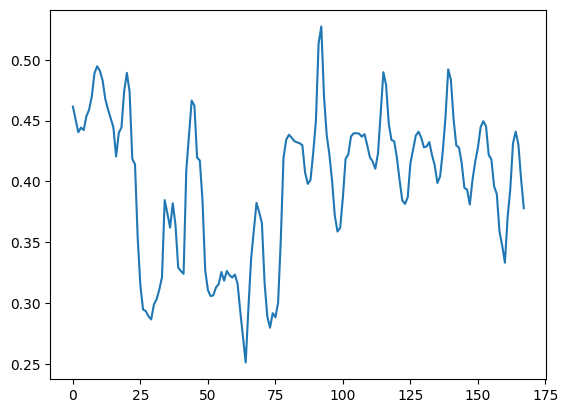

In [14]:
plt.plot(first_test_y[0, :, :])

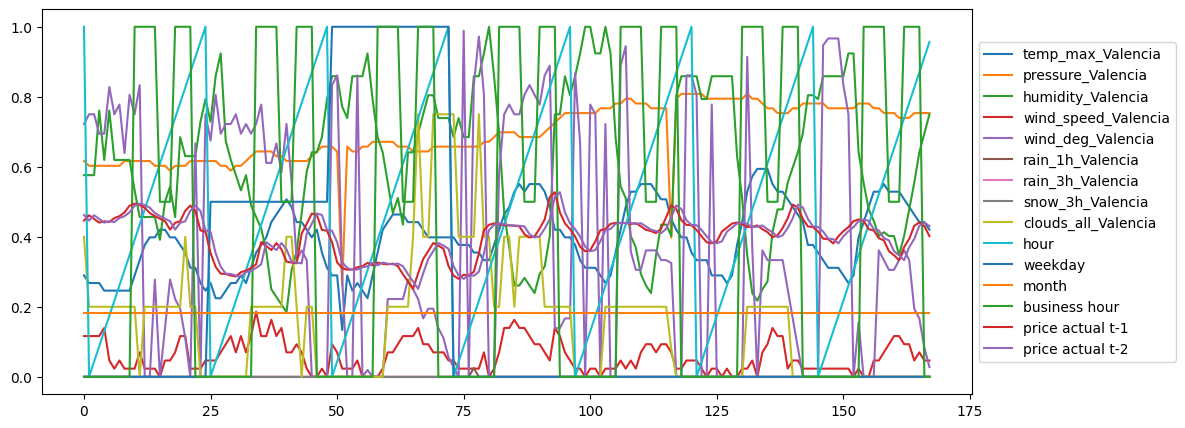

In [15]:
# plot a different features and their labels
def plot_some_features(first_test_x, columns, start, end):
    plt.figure(figsize=(12, 5))

    for feature in range(start, end):
        plt.plot(first_test_x[0, :, feature].numpy(), label=columns[feature+1])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


plot_some_features(first_test_x, columns, 60, 75)

In [16]:
# define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=first_test_x.shape[2], hidden_size=64, output_size=1, middle_size=32, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, middle_size)
        self.fc2 = nn.Linear(middle_size, output_size)

    def forward(self, x):
        # initialize hidden and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # pass input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        N, L, D = out.shape # batch_size, seq_length, hidden_size
        
        # pass the output through the linear layer
        out = self.fc1(out.reshape(N*L, D))
        out = self.fc2(out).reshape(N, L, self.output_size)

        return out

# initialize the model
model = LSTM()

# define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)

# test the model before training
val_loss = 0
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        prediction = model.forward(X_batch)
        loss = criterion(prediction, y_batch)
        val_loss += loss.item()


# calculate the test loss
print(f"Validation Loss before: {val_loss:.4f}")

loss_records = []
# train the model
n_epochs = 64
for epoch in range(n_epochs):

    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_batch)

        # calculate the loss
        loss = criterion(y_pred, y_batch)
        loss_records.append(loss.item())
        # backward pass
        loss.backward()
        max_grad_norm = 1.0
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        # print the loss after every 10 batches
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
# test the model
val_loss = 0
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        prediction = model.forward(X_batch)
        loss = criterion(prediction, y_batch)
        val_loss += loss.item()

# calculate the test loss
print(f"Validation Loss after: {val_loss:.4f}")

Validation Loss before: 1.2479
Epoch [1/64], Batch [10/55], Loss: 0.1205
Epoch [1/64], Batch [20/55], Loss: 0.0852
Epoch [1/64], Batch [30/55], Loss: 0.0384
Epoch [1/64], Batch [40/55], Loss: 0.0252
Epoch [1/64], Batch [50/55], Loss: 0.0189
Epoch [2/64], Batch [10/55], Loss: 0.0160
Epoch [2/64], Batch [20/55], Loss: 0.0173
Epoch [2/64], Batch [30/55], Loss: 0.0194
Epoch [2/64], Batch [40/55], Loss: 0.0175
Epoch [2/64], Batch [50/55], Loss: 0.0150
Epoch [3/64], Batch [10/55], Loss: 0.0157
Epoch [3/64], Batch [20/55], Loss: 0.0147
Epoch [3/64], Batch [30/55], Loss: 0.0143
Epoch [3/64], Batch [40/55], Loss: 0.0131
Epoch [3/64], Batch [50/55], Loss: 0.0156
Epoch [4/64], Batch [10/55], Loss: 0.0140
Epoch [4/64], Batch [20/55], Loss: 0.0141
Epoch [4/64], Batch [30/55], Loss: 0.0133
Epoch [4/64], Batch [40/55], Loss: 0.0138
Epoch [4/64], Batch [50/55], Loss: 0.0098
Epoch [5/64], Batch [10/55], Loss: 0.0113
Epoch [5/64], Batch [20/55], Loss: 0.0128
Epoch [5/64], Batch [30/55], Loss: 0.0103
Epo

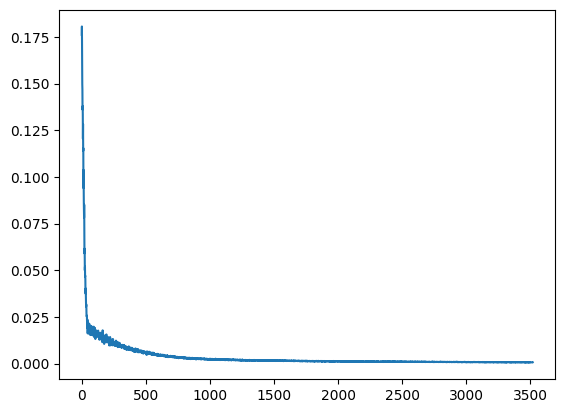

In [17]:
plt.plot(loss_records)

In [18]:
def evaluate_mse_rsquared(model, dataloader):
    model.eval()
    mse = 0
    r_squared = 0
    count = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            prediction = model.forward(X_batch)
            mse += criterion(prediction, y_batch).item()
            # Flatten prediction and y_batch
            y_pred_flat = prediction.view(-1, 1)
            y_true_flat = y_batch.view(-1, 1)
            # Calculate r2 score
            r_squared += r2_score(y_true_flat.cpu().numpy(), y_pred_flat.cpu().numpy())
            if count == 0:
                # plot the first sample
                plt.plot(y_pred_flat[:24*7, 0].cpu().numpy(), label='Predicted')
                plt.plot(y_true_flat[:24*7, 0].cpu().numpy(), label='True')
                plt.legend()
            count += 1
    return mse/len(dataloader), r_squared/len(dataloader)

MSE:  0.0006956504824172173
r2 score:  0.9599857410444811


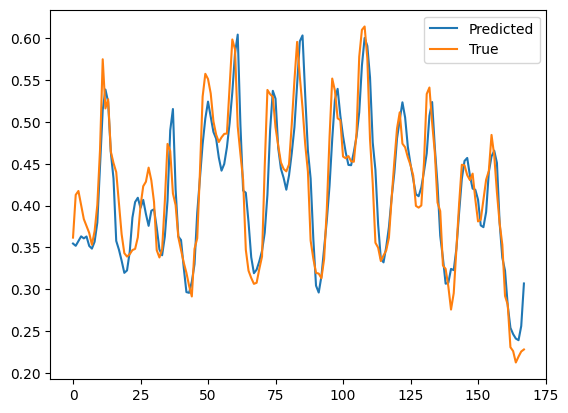

In [19]:
mse, r2 = evaluate_mse_rsquared(model, test_dataloader)
print("MSE: ", mse)
print("r2 score: ", r2)